In [1]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.preprocessing.preprocessed_data import PreprocessedData
from epimodel.pymc3_models.base_model import produce_CIs
import numpy as np
import pymc3 as pm
from pymc3.distributions import draw_values, generate_samples

import pandas as pd 

Set Theano Environmental Variables for Parallelisation


In [2]:
import pylab as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [4]:
ep = EpidemiologicalParameters()

In [5]:
with DefaultModel(data) as model_syn:
    model_syn.build_model(**ep.get_model_build_dict())

In [129]:
np.exp(-np.array([.0,.05,.1,.15,.2,.25,.3,.35,.4]))

array([1.        , 0.95122942, 0.90483742, 0.86070798, 0.81873075,
       0.77880078, 0.74081822, 0.70468809, 0.67032005])

In [118]:
with model_syn: 
    
    point = {
        'CM_Alpha' : np.array([.0,.05,.1,.15,.2,.25,.3,.35,.4]),
        'InitialSizeCases_log' : -7 *np.ones((41,1)), 
        'InitialSizeDeaths_log' : -7 *np.ones((41,1)), 
        #'RegionLogR_noise' : -1*np.ones(41),
        'HyperRVar' : .2
    }
    c = [model_syn.GrowthCases, 
         model_syn.GrowthDeaths, 
         model_syn.RegionR, 
         model_syn.ObservedCases, 
         model_syn.ObservedDeaths, 
         model_syn.RegionLogR_noise, 
         model_syn.InfectedCases ,
         model_syn.InfectedDeaths ,
         model_syn.ExpectedCases ,
         model_syn.ExpectedDeaths ]
    
    synthvalues = draw_values(c, point=point)
    gcases,gdeaths, regionR, ocases, odeaths, regionRnoise,icases,ideaths,ecases, edeaths,  = synthvalues

In [110]:
regionR

array([2.76890429, 3.1914955 , 2.37382374, 3.69588208, 4.40178359,
       2.69086508, 2.90088093, 2.58843896, 1.63839399, 5.44811765,
       3.12357571, 6.42111343, 4.01979305, 3.49446201, 2.67389545,
       4.67288428, 3.66013183, 2.27022851, 1.29020081, 2.0303304 ,
       3.81238228, 1.97699683, 2.67683512, 3.14101331, 2.27540537,
       3.15450334, 4.00766535, 3.30516926, 4.37274923, 3.97079056,
       3.48485337, 3.28710725, 3.58031832, 2.42971376, 4.27840001,
       3.33159608, 4.39278285, 2.69230511, 3.309671  , 3.52107691,
       3.91936323])

In [56]:
with open("synthetic_values_variable.pkl", 'wb+') as f:
    pickle.dump(synthvalues, f, pickle.HIGHEST_PROTOCOL)

In [119]:
def synthetic_prep_data(model, data, syn_deaths, syn_cases):
    
    def reverse_shape(synth, indexes, mask):
        a = np.zeros(model.nRs * model.nDs)
        a[indexes] += synth
        a = a.reshape((model.nRs, model.nDs))
        a = np.ma.masked_array(a, mask)
        return a

    
    syntheticNewDeaths = reverse_shape(syn_deaths, 
                                       model.all_observed_deaths,  
                                       data.NewDeaths.mask)
    syntheticNewCases = reverse_shape(syn_cases, 
                              model.all_observed_active,  
                              data.NewCases.mask)
    
    return PreprocessedData(
                 data.Active,
                 data.Confirmed,
                 data.ActiveCMs,
                 data.CMs,
                 data.Rs,
                 data.Ds,
                 data.Deaths,
                 syntheticNewDeaths,
                 syntheticNewCases,
                 data.RNames)




In [120]:
country_codes = {
    "AFG":"AF",
"ALA":"AX",
"ALB":"AL",
"DZA":"DZ",
"ASM":"AS",
"AND":"AD",
"AGO":"AO",
"AIA":"AI",
"ATA":"AQ",
"ATG":"AG",
"ARG":"AR",
"ARM":"AM",
"ABW":"AW",
"AUS":"AU",
"AUT":"AT",
"AZE":"AZ",
"BHS":"BS",
"BHR":"BH",
"BGD":"BD",
"BRB":"BB",
"BLR":"BY",
"BEL":"BE",
"BLZ":"BZ",
"BEN":"BJ",
"BMU":"BM",
"BTN":"BT",
"BOL":"BO",
"BES":"BQ",
"BIH":"BA",
"BWA":"BW",
"BVT":"BV",
"BRA":"BR",
"IOT":"IO",
"BRN":"BN",
"BGR":"BG",
"BFA":"BF",
"BDI":"BI",
"CPV":"CV",
"KHM":"KH",
"CMR":"CM",
"CAN":"CA",
"CYM":"KY",
"CAF":"CF",
"TCD":"TD",
"CHL":"CL",
"CHN":"CN",
"CXR":"CX",
"CCK":"CC",
"COL":"CO",
"COM":"KM",
"COD":"CD",
"COG":"CG",
"COK":"CK",
"CRI":"CR",
"CIV":"CI",
"HRV":"HR",
"CUB":"CU",
"CUW":"CW",
"CYP":"CY",
"CZE":"CZ",
"DNK":"DK",
"DJI":"DJ",
"DMA":"DM",
"DOM":"DO",
"ECU":"EC",
"EGY":"EG",
"SLV":"SV",
"GNQ":"GQ",
"ERI":"ER",
"EST":"EE",
"SWZ":"SZ",
"ETH":"ET",
"FLK":"FK",
"FRO":"FO",
"FJI":"FJ",
"FIN":"FI",
"FRA":"FR",
"GUF":"GF",
"PYF":"PF",
"ATF":"TF",
"GAB":"GA",
"GMB":"GM",
"GEO":"GE",
"DEU":"DE",
"GHA":"GH",
"GIB":"GI",
"GRC":"GR",
"GRL":"GL",
"GRD":"GD",
"GLP":"GP",
"GUM":"GU",
"GTM":"GT",
"GGY":"GG",
"GIN":"GN",
"GNB":"GW",
"GUY":"GY",
"HTI":"HT",
"HMD":"HM",
"VAT":"VA",
"HND":"HN",
"HKG":"HK",
"HUN":"HU",
"ISL":"IS",
"IND":"IN",
"IDN":"ID",
"IRN":"IR",
"IRQ":"IQ",
"IRL":"IE",
"IMN":"IM",
"ISR":"IL",
"ITA":"IT",
"JAM":"JM",
"JPN":"JP",
"JEY":"JE",
"JOR":"JO",
"KAZ":"KZ",
"KEN":"KE",
"KIR":"KI",
"PRK":"KP",
"KOR":"KR",
"KWT":"KW",
"KGZ":"KG",
"LAO":"LA",
"LVA":"LV",
"LBN":"LB",
"LSO":"LS",
"LBR":"LR",
"LBY":"LY",
"LIE":"LI",
"LTU":"LT",
"LUX":"LU",
"MAC":"MO",
"MKD":"MK",
"MDG":"MG",
"MWI":"MW",
"MYS":"MY",
"MDV":"MV",
"MLI":"ML",
"MLT":"MT",
"MHL":"MH",
"MTQ":"MQ",
"MRT":"MR",
"MUS":"MU",
"MYT":"YT",
"MEX":"MX",
"FSM":"FM",
"MDA":"MD",
"MCO":"MC",
"MNG":"MN",
"MNE":"ME",
"MSR":"MS",
"MAR":"MA",
"MOZ":"MZ",
"MMR":"MM",
"NAM":"NA",
"NRU":"NR",
"NPL":"NP",
"NLD":"NL",
"NCL":"NC",
"NZL":"NZ",
"NIC":"NI",
"NER":"NE",
"NGA":"NG",
"NIU":"NU",
"NFK":"NF",
"MNP":"MP",
"NOR":"NO",
"OMN":"OM",
"PAK":"PK",
"PLW":"PW",
"PSE":"PS",
"PAN":"PA",
"PNG":"PG",
"PRY":"PY",
"PER":"PE",
"PHL":"PH",
"PCN":"PN",
"POL":"PL",
"PRT":"PT",
"PRI":"PR",
"QAT":"QA",
"REU":"RE",
"ROU":"RO",
"RUS":"RU",
"RWA":"RW",
"BLM":"BL",
"SHN":"SH",
"KNA":"KN",
"LCA":"LC",
"MAF":"MF",
"SPM":"PM",
"VCT":"VC",
"WSM":"WS",
"SMR":"SM",
"STP":"ST",
"SAU":"SA",
"SEN":"SN",
"SRB":"RS",
"SYC":"SC",
"SLE":"SL",
"SGP":"SG",
"SXM":"SX",
"SVK":"SK",
"SVN":"SI",
"SLB":"SB",
"SOM":"SO",
"ZAF":"ZA",
"SGS":"GS",
"SSD":"SS",
"ESP":"ES",
"LKA":"LK",
"SDN":"SD",
"SUR":"SR",
"SJM":"SJ",
"SWE":"SE",
"CHE":"CH",
"SYR":"SY",
"TWN":"TW",
"TJK":"TJ",
"TZA":"TZ",
"THA":"TH",
"TLS":"TL",
"TGO":"TG",
"TKL":"TK",
"TON":"TO",
"TTO":"TT",
"TUN":"TN",
"TUR":"TR",
"TKM":"TM",
"TCA":"TC",
"TUV":"TV",
"UGA":"UG",
"UKR":"UA",
"ARE":"AE",
"GBR":"GB",
"UMI":"UM",
"USA":"US",
"URY":"UY",
"UZB":"UZ",
"VUT":"VU",
"VEN":"VE",
"VNM":"VN",
"VGB":"VG",
"VIR":"VI",
"WLF":"WF",
"ESH":"EH",
"YEM":"YE",
"ZMB":"ZM",
"ZWE":"ZW"
}

trdf = pd.read_csv("../double-entry-data/under_ascertainment_estimates.txt", 
                            parse_dates=["date"], 
                            infer_datetime_format=True)

trdf['region'] = trdf.iso_code.map(country_codes)
trdf = trdf.set_index(["date"])

trdf = trdf.append(pd.DataFrame(
    {
      'region' : ['MT'],
      'median' : [np.nan]
    }, index=[pd.to_datetime('2020-08-01')]))



from datetime import date
empty = pd.Series ([np.nan], index=[pd.to_datetime('2020-01-01')])

a = trdf.groupby('region')['median'].apply(lambda g: 
                                           (empty.append(g)
                                            .asfreq('D')
                                           ))



test_rates = np.zeros((model_syn.nRs, model_syn.nDs))
for r_i, r in enumerate(data.Rs):
    for d_i, d in enumerate(data.Ds):
        test_rates[r_i, d_i] = a[(r, pd.to_datetime(d))]

In [121]:
synth_data_normal = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted.NewCases  = synth_data_adjusted.NewCases / test_rates

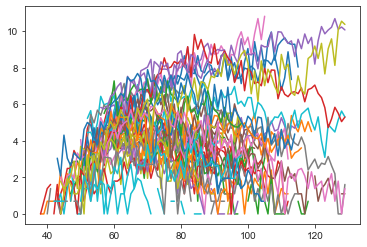

In [122]:
plt.plot(np.log(synth_data_normal.NewCases.T));

In [126]:
with DefaultModel(synth_data_normal) as model_normal:
    model_normal.build_model(**ep.get_model_build_dict())

In [137]:
ep.get_model_build_dict()

{'gi_mean_mean': 5.06,
 'gi_mean_sd': 0.32,
 'gi_sd_mean': 1.804,
 'gi_sd_sd': 0.114,
 'deaths_delay_mean_mean': 23.65,
 'deaths_delay_mean_sd': 1.07,
 'deaths_delay_disp_mean': 10.1,
 'deaths_delay_disp_sd': 3.17,
 'cases_delay_mean_mean': 11.1,
 'cases_delay_mean_sd': 0.5,
 'cases_delay_disp_mean': 5.46,
 'cases_delay_disp_sd': 0.55}

In [127]:
with model_normal:
    model_normal.trace = pm.sample(150, tune=100, cores=1, chains=1, max_treedepth=12, target_accept=0.925)
    pm.save_trace(model_normal.trace, "normal_variable")

Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 100 tune and 150 draw iterations (100 + 150 draws total) took 514 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


OSError: Cautiously refusing to overwrite the already existing normal_variable! Please supply a different directory, or set `overwrite=True`

In [91]:
with DefaultModel(synth_data_adjusted) as model_adjusted:
    model_adjusted.build_model(**ep.get_model_build_dict())

In [92]:
with model_adjusted:
    model_adjusted.trace = pm.sample(150, tune=100, cores=1, chains=1, max_treedepth=12, target_accept=0.925)
    pm.save_trace(model_adjusted.trace, "adjusted_variable")

Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 100 tune and 150 draw iterations (100 + 150 draws total) took 84 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


OSError: Cautiously refusing to overwrite the already existing adjusted_variable! Please supply a different directory, or set `overwrite=True`

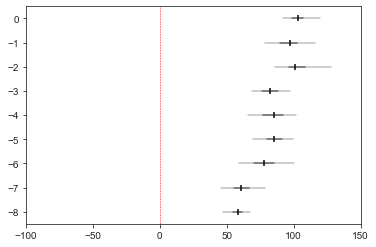

In [133]:
from epimodel.pymc3_models.base_model import produce_CIs

def plot_effect(trace): 
        if hasattr(trace, "points"):
            trace = trace["CMReduction"]
        means, li, ui, lq, uq = produce_CIs(100 * trace)

        N_cms = means.size

        plt.plot([0, 0], [1, -(N_cms)], "--r", linewidth=0.5)
        y_vals = -1 * np.arange(N_cms)
        plt.scatter(means, y_vals, marker="|", color="k")
        for cm in range(N_cms):
            plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.25)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.5)

        plt.xlim([-100, 150])
        xtick_vals = np.arange(-100, 100, 50)
        xtick_str = [f"{x:.0f}%" for x in xtick_vals]
        plt.ylim([-(N_cms - 0.5), 0.5])

plot_effect(model_normal.trace)
#plot_effect(model_adjusted.trace)

In [138]:
with model_normal:
    nvt = pm.load_trace("../../nonsynth_normal_variable")

In [139]:
with model_adjusted:
    avt = pm.load_trace("../../nonsynth_adjusted_variable")

In [38]:
import pickle
with open("../../synthetic_values_variable.pkl", "rb") as f:
    synthetic_values_variable = pickle.load(f)

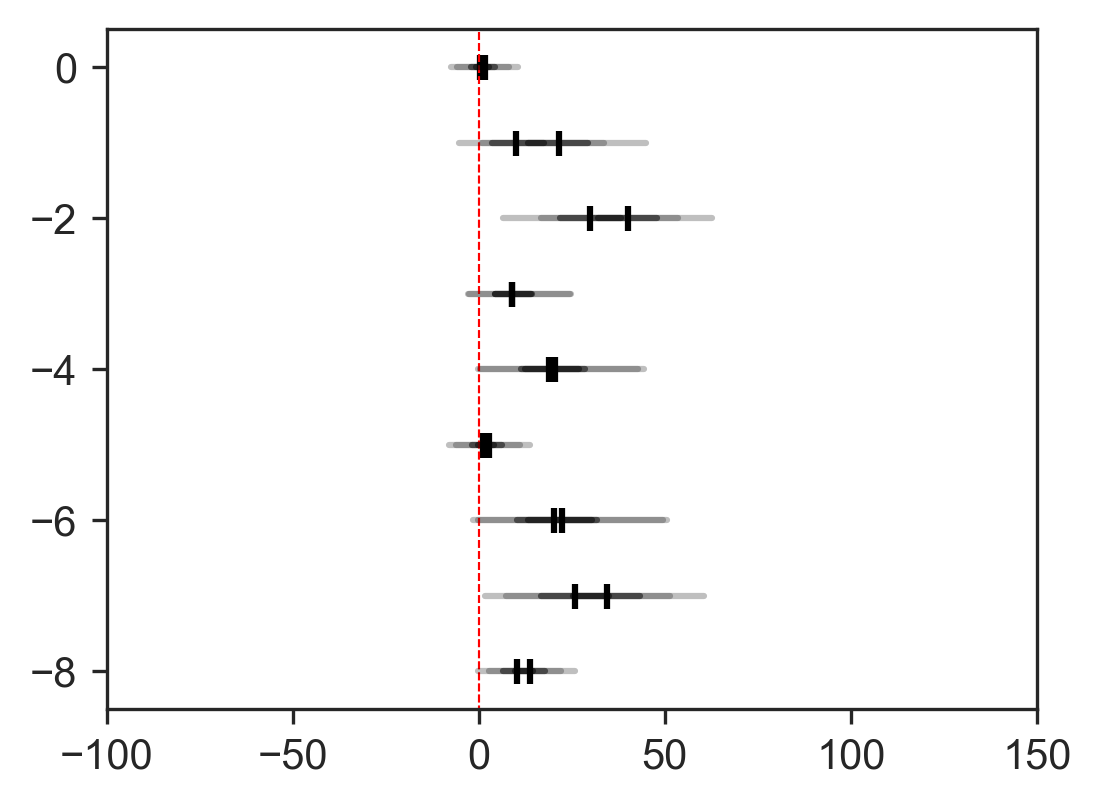

In [140]:
plt.figure(figsize=(4, 3), dpi=300)
plot_effect(nvt['CM_Alpha'])
plot_effect(avt['CM_Alpha'])

In [28]:
avt.

array(<itertools.chain object at 0x145f80cd0>, dtype=object)

In [29]:
nvt.points?

In [33]:
nvt.get_values('CMReduction').shape

KeyError: 'CMReduction'